size: 14


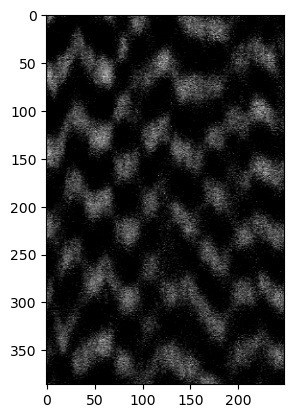

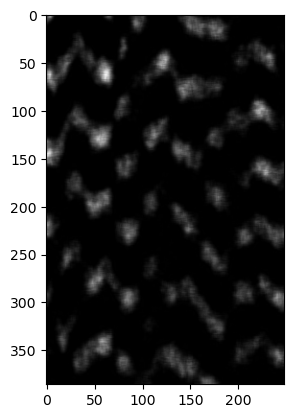

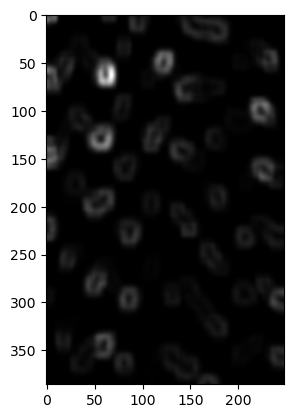

In [4]:
import pathlib
import numpy
import tifffile
import scipy.ndimage
import matplotlib.pyplot as plt


def convert_images(directory):
    input_path = pathlib.Path(directory)
    images = {}

    for file_path in input_path.glob('*.tif'):
        try:
            # Load the TIFF file into a numpy array
            image = tifffile.imread(file_path)

            # standardize image dimensions
            with tifffile.TiffFile(file_path) as tif_file:
                metadata = tif_file.imagej_metadata
            num_channels = metadata.get('channels', 1)
            image = image.reshape(num_channels, 
                                    image.shape[-2],  # rows
                                    image.shape[-1])  # cols
            
            images[file_path.name] = image
                        
        except tifffile.TiffFileError:
            print(f"Warning: Skipping '{file_path.name}', not a valid TIF file.")

    # Sort the dictionary keys alphabetically
    images = {key: images[key] for key in sorted(images)}

    return images      

def variancetransform(image_array, win_low, win_high):

    window_range = range(win_low,win_high,1)
    max_variance = -1
    size = -1

    for window in window_range:
        result = abs(scipy.ndimage.uniform_filter(image_array**2, size=window, output=numpy.float64) - 
                    (scipy.ndimage.uniform_filter(image_array, size=window, output=numpy.float64)**2))
        variance = result.max()
        if variance > max_variance:
            max_variance = variance
            size = window
    
    output_image_array = abs(scipy.ndimage.uniform_filter(image_array**2, size=size, output=numpy.float64) 
                        - (scipy.ndimage.uniform_filter(image_array, size=size, output=numpy.float64)**2))

    return output_image_array, size

images = convert_images('/Users/domchom/Desktop/cell_profiler_test/Kymograph_variance')

for image in images:
    variance_image, size = variancetransform(images[image], 5, 50)
    variance_again_image, size = variancetransform(variance_image, 5, 50)
    print(f'size: {size}')
    plt.imshow(images[image][0], cmap='gray')
    plt.show()
    plt.imshow(variance_image[0], cmap='gray')
    plt.show()
    plt.imshow(variance_again_image[0], cmap='gray')
    plt.show()